In [103]:
#IMPORTS
from ipynb.fs.full.defs import * #importing defs for download_unzip function
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import multiprocessing
import json
from PIL import Image

In [ ]:
'''

COCO DATASET DOWNLOADING AND UNZIPPING

'''

# This code downloads the coco dataset from Amazon S3 in parallel.

files = ['val2017.zip', 'annotations_trainval2017.zip', 'train2017.zip']

num_cpus = multiprocessing.cpu_count()
print("Number of cpus: " + str(num_cpus))
with multiprocessing.Pool(num_cpus) as p:
    p.map(download_unzip, files)
    
print("COCO downloaded and unzipped.")


Number of cpus: 16


In [290]:
'''
FIXED PARAMETERS
'''

#DIMENSIONS OF RESIZED IMAGE (INPUT FOR THE MODEL)
IMG_WIDTH = 192
IMG_HEIGHT = 256

#PARAMETERS OF THE KEYPOINTS OF THE DATASET
N_DIM = 3 #x,y,visibility
N_KEYPOINTS = 17 #it is set later in the code just in case
K_NAMES = ['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle'] #it is set later in the code just in case

#PATHS
TRAIN_ANNOT_PATH = 'coco_dataset/annotations/person_keypoints_train2017.json' #annotations
VAL_ANNOT_PATH = 'coco_dataset/annotations/person_keypoints_val2017.json' #annotations
PATH_TRAIN = 'coco_dataset/train2017' #images
PATH_VAL = 'coco_dataset/val2017' #images

In [198]:
#LOADING JSON FILES

with open(TRAIN_ANNOT_PATH) as f:
  train_coco = json.load(f) # load annotations for training set 

with open(VAL_ANNOT_PATH) as f:
  val_coco = json.load(f) # load annotations for validation set 

N_KEYPOINTS = len(train_coco['categories'][0]['keypoints']) #17
K_NAMES = train_coco['categories'][0]['keypoints']

['nose', 'left_eye', 'right_eye', 'left_ear', 'right_ear', 'left_shoulder', 'right_shoulder', 'left_elbow', 'right_elbow', 'left_wrist', 'right_wrist', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle', 'right_ankle']


In [291]:
#LOADING ATTRIBUTES OF A SAMPLE FROM THE DATASET

#function to get the attributes of the given n-th sample from the dataset
def get_sample_att(torval,sample_n): #torval -> 0 if training and 1 if validation dataset
    sample = val_coco['annotations'][sample_n] if torval else train_coco['annotations'][sample_n]
    img_id = str(sample['image_id'])
    k_list = sample['keypoints']
    bbox = sample['bbox']
    is_crowd = sample['iscrowd']

    #the keypoints in each sample are indicated in a list as: x1, y1, v1, x2, y2, v2, x3... and there are 
    #17 keypoints, so, we need it in a bidimensional array of 17x3

    k_array = np.asarray(k_list)
    k_array3d = np.reshape(k_array,(N_KEYPOINTS,N_DIM))
    keypoints = k_array3d[:,:2]
    k_vis = k_array3d[:,2]
    
    return img_id,bbox,is_crowd,keypoints,k_vis

#example of getting the attributes of the 0th sample of the dataset
#img_id,bbox,is_crowd,keypoints,k_vis = get_sample_att(0,0)

In [292]:
def get_img(torval, img_id):
    #load image
    #the image names are 12 digits and the first gaps are filled with 0's
    img_name = '000000000000'
    img_name = img_name[0:len(img_name)-len(img_id)] + img_id + '.jpg'
    path = PATH_VAL if torval else PATH_TRAIN
    og_img = Image.open(path + '/' + img_name)
    return og_img

In [293]:
#some of the samples of the dataset have keypoints drawn out of the bounding box and I propose the following solution
#making the bounding box as big as necessary, if it is possible, to include the keypoints out of the area, as this part of the image can be interesting for the training or validation of the model
def check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img):
    #attributes of the bounding box and original image
    bbox_x, bbox_y, bbox_w, bbox_h = bbox
    img_w, img_h = og_img.size
    
    #calculate min and max values of x and y positions of the keypoints
    x_min = 99999
    x_max = -1
    y_min = 99999
    y_max = -1
    for i in range(len(keypoints)):
        if k_vis[i] > 0:
            x_temp = keypoints[i][0]
            y_temp = keypoints[i][1]
            if x_temp < x_min: x_min = x_temp
            if x_temp > x_max: x_max = x_temp
            if y_temp < y_min: y_min = y_temp
            if y_temp > y_max: y_max = y_temp
    x_min = x_min-10
    x_max = x_max+10
    y_min = y_min-10
    y_max = y_max+10
        
    if x_min < bbox_x:
        if x_min < 0: x_min = 0
    else:
        x_min = bbox_x
    
    if x_max > bbox_x+bbox_w:
        if x_max > img_w: x_max = img_w
    else:
        x_max = bbox_x+bbox_w
        
    if y_min < bbox_y:
        if y_min < 0: y_min = 0
    else:
        y_min = bbox_y
        
    if y_max > bbox_y+bbox_h:
        if y_max > img_h: y_max = img_h
    else:
        y_max = bbox_y+bbox_h
        
    bbox = [x_min,y_min,x_max-x_min,y_max-y_min]
    return bbox
    

In [294]:
#CROP IMAGE IN THE BOUNDING BOX AND RESIZE TO INPUT IMAGE SIZE

def crop_resize_img(torval,og_img,bbox): #torval -> 0 if training and 1 if validation dataset
    #attributes of the bounding box
    bbox_x, bbox_y, bbox_w, bbox_h = bbox
    
    #resize image part of the bounding box
    res_img = og_img.resize((IMG_WIDTH, IMG_HEIGHT), box=(bbox_x,bbox_y,bbox_x+bbox_w,bbox_y+bbox_h))
    
    return res_img

#og_img,res_img = crop_resize_img(0,img_id,bbox) #load original and resized images of the first sample from the training dataset

In [295]:
#RESCALE KEYPOINTS TO MATCH RESIZED IMAGE
#crop -> rest to the keypoint position the bounding box position as the keypoint should start from there
#rescale -> as the image has been resized, the position of the keypoint must be adapted taking into account the scale from the original image to the resized one
def rescale_keypoints(keypoints,bbox):
    bbox_x,bbox_y,bbox_w,bbox_h = bbox
    box_start_pos = np.asarray([bbox_x,bbox_y])
    box_size = np.asarray([bbox_w,bbox_h])
    res_size = np.asarray([IMG_WIDTH,IMG_HEIGHT])
    keypoints = np.round((keypoints-box_start_pos)*(res_size/box_size)).astype(int)

    keypoints[keypoints<0] = 0 #if the original value was 0, then it will be converted to negative, so it should be reconverted to 0
    
    return keypoints
    
#keypoints = rescale_keypoints(keypoints,bbox)

In [296]:
#DISPLAY RESIZED IMAGE AND KEYPOINTS

#draw keypoints in the resized image
def plot_keypoints(draw_non_visible,keypoints,k_vis,ax): #draw_non_visible -> option to draw (1) or not (0) keypoints that are in the dataset but not visible in the image (occlusions)
    for j in range(len(K_NAMES)):
        n = K_NAMES[j]
        x = keypoints[j,0]
        y = keypoints[j,1]

        if k_vis[j] > 0 and (draw_non_visible or (draw_non_visible == 0 and k_vis[j] == 2)):
          ax.scatter(x, y, 250)
          ax.text(x+5, y+5, n, fontsize=18, bbox=dict(facecolor='r', alpha=0.5), color='w')

def display_images_keypoints(draw_non_visible,og_img,bbox,res_img,keypoints,k_vis):
    #display original image with bounding box and resized image with keypoints
    bbox_x,bbox_y,bbox_w,bbox_h = bbox
    fig = plt.figure(1,figsize=(20,20))
    ax1 = fig.add_subplot(121)  # left side
    ax1.imshow(og_img)
    ax1.add_patch(Rectangle((bbox_x, bbox_y), bbox_w, bbox_h, alpha=0.3, facecolor="blue", edgecolor="red", hatch='x'))

    ax2 = fig.add_subplot(122)  # right side
    ax2.imshow(res_img)
    ax2 = plot_keypoints(draw_non_visible,keypoints,k_vis,ax2)
    plt.show()
    
#display_images_keypoints(DRAW_NON_VISIBLE,og_img,bbox,res_img,keypoints,k_vis)

Bounding box: [182.89, 208.07, 93.94, 271.93]
New bounding box: [181, 208.07, 139, 271.93]
KEYPOINTS POSITIONS: 
- nose: [87 23] (visibility: 2)
- left_eye: [91 21] (visibility: 2)
- right_eye: [79 20] (visibility: 2)
- left_ear: not specified
- right_ear: [65 23] (visibility: 2)
- left_shoulder: [105  52] (visibility: 2)
- right_shoulder: [54 47] (visibility: 2)
- left_elbow: [159  63] (visibility: 1)
- right_elbow: [14 76] (visibility: 2)
- left_wrist: [178  45] (visibility: 1)
- right_wrist: [58 87] (visibility: 2)
- left_hip: [ 95 108] (visibility: 2)
- right_hip: [ 50 106] (visibility: 2)
- left_knee: not specified
- right_knee: [ 90 168] (visibility: 2)
- left_ankle: not specified
- right_ankle: [ 70 230] (visibility: 2)
*visibility: 1 (non visible but specified), 2 (visible)*


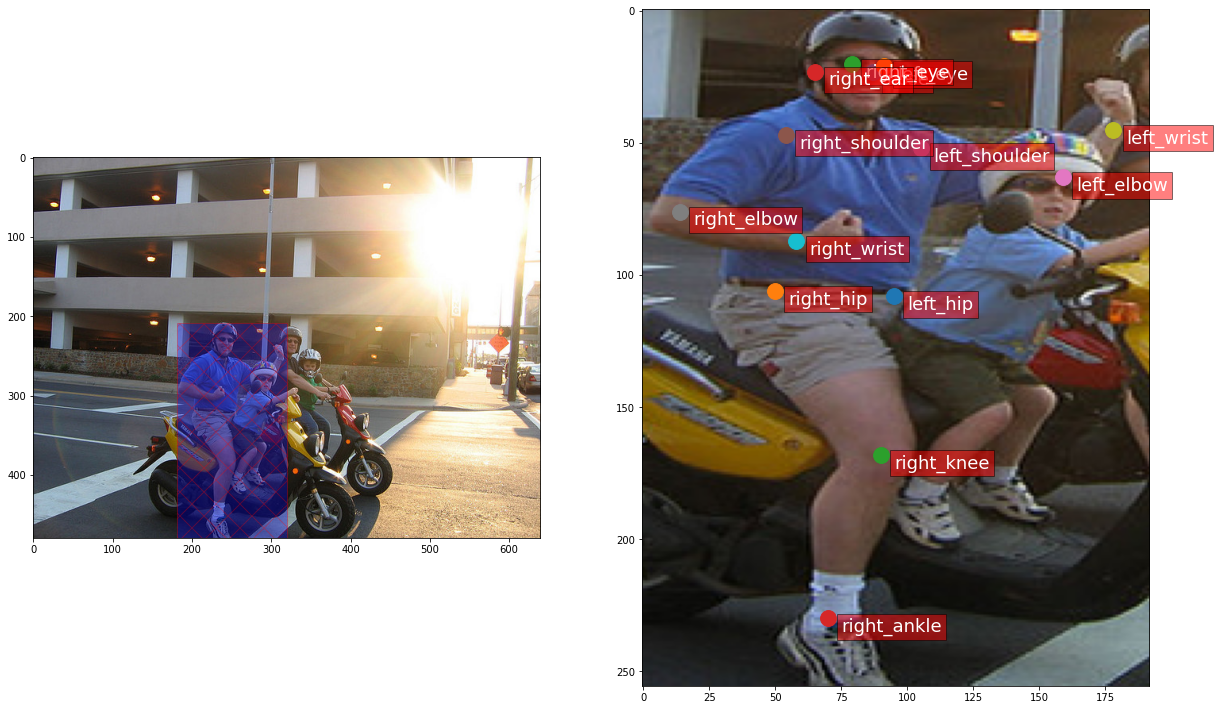

In [297]:
#OPTION PARAMETERS FOR THE SAMPLE LOADING
SAMPLE_N = 100 #sample number from the dataset
TRAIN_VAL = 0 # 0 -> training dataset, 1 -> validation dataset
DRAW_NON_VISIBLE = 1 # 0 -> dont draw non visible keypoints, 1 -> draw non visible keypoints

img_id,bbox,is_crowd,keypoints,k_vis = get_sample_att(TRAIN_VAL,SAMPLE_N)
print('Bounding box: ' + str(bbox))
og_img = get_img(TRAIN_VAL, img_id)
bbox = check_keypoints_in_bbox(bbox,keypoints,k_vis,og_img)
print('New bounding box: ' + str(bbox))
res_img = crop_resize_img(TRAIN_VAL,og_img,bbox)
keypoints = rescale_keypoints(keypoints,bbox)
print('KEYPOINTS POSITIONS: ')
for i in range(len(keypoints)):
    if k_vis[i] > 0:
        print('- ' + str(K_NAMES[i]) + ': ' + str(keypoints[i]) + ' (visibility: ' + str(k_vis[i]) + ')')
    else:
        print('- ' + str(K_NAMES[i]) + ': not specified')
print('*visibility: 1 (non visible but specified), 2 (visible)*')
display_images_keypoints(DRAW_NON_VISIBLE,og_img,bbox,res_img,keypoints,k_vis)